Date
2020-06    38892.0
2020-07    57968.0
2020-08    52578.0
2020-09    46263.0
2020-10    22164.0
Freq: M, Name: Active, dtype: float64


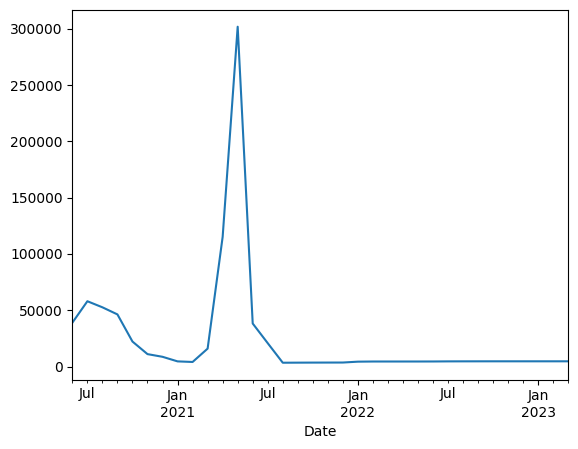

In [173]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
def parser(x):
 return datetime.strptime(x,'%m-%d-%Y')

series = read_csv('sorted_data_arima.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser).squeeze(1)

series = series.resample('M').interpolate()
series.index = series.index.to_period('m')


print(series.head())
series.plot()
pyplot.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

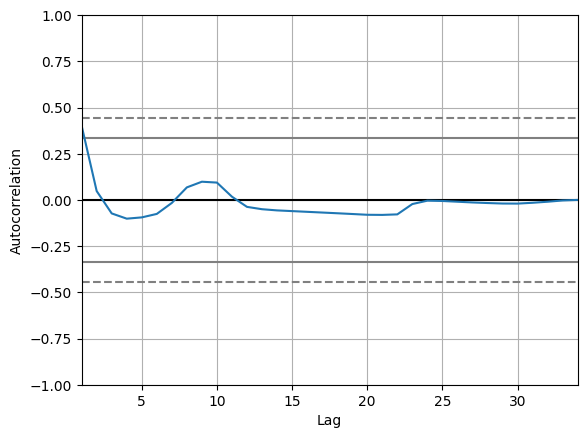

In [174]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [175]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(series, order=(2,1,0))
model_fit = model.fit()

In [176]:
# summary of fit model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Active   No. Observations:                   34
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -407.845
Date:                Thu, 04 May 2023   AIC                            821.690
Time:                        11:35:20   BIC                            826.180
Sample:                    06-30-2020   HQIC                           823.201
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2500      0.092     -2.717      0.007      -0.430      -0.070
ar.L2         -0.2391      0.130     -1.832      0.067      -0.495       0.017
sigma2      3.349e+09   9.67e-12   3.46e+20      0.0

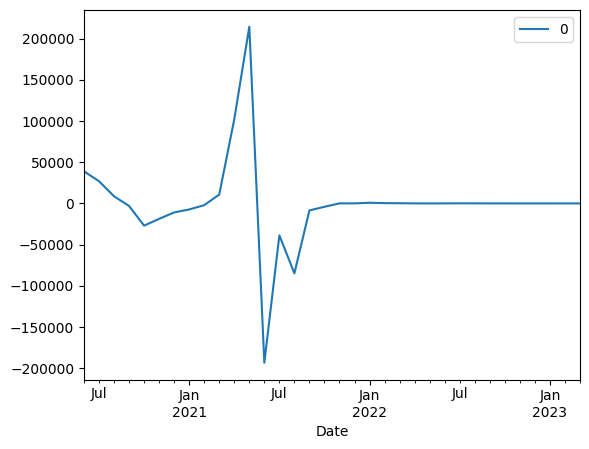

In [177]:
# line plot of residuals
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

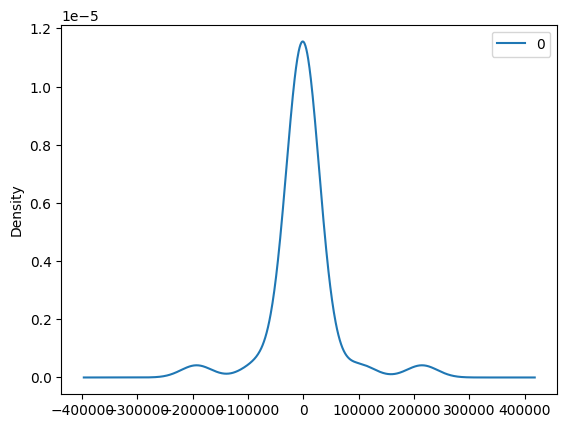

                   0
count      34.000000
mean      146.937614
std     56711.756508
min   -193203.541378
25%     -3838.403398
50%        16.813590
75%       189.849484
max    214297.529047


In [178]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [210]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.65)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [211]:
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(1,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=4434.840761, expected=4437.147715
predicted=4436.863965, expected=4439.128669
predicted=4438.733418, expected=4464.450714
predicted=4459.398311, expected=4553.171006
predicted=4535.469004, expected=4584.530979
predicted=4578.273848, expected=4603.090543
predicted=4599.387425, expected=4614.574169
predicted=4612.282884, expected=4617.273252
predicted=4616.734714, expected=4617.640666
predicted=4617.567357, expected=4617.934855
predicted=4617.876156, expected=4618.227758
predicted=4618.169316, expected=4618.227758


In [212]:
# evaluate forecasts
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 32.589


In [214]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [215]:
print(mean_absolute_percentage_error(test, predictions))

0.40179108686268755


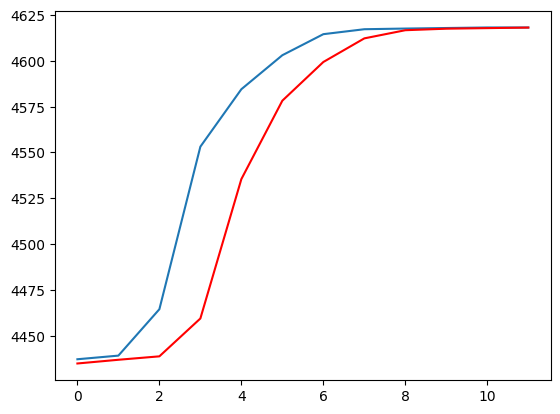

In [216]:
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()